# SBRC Pandapower Power Flow - Unbalanced Network with MPC Simulation Results

Notebook for obtaining distribution network sensitivities fro  SBRC microgrid via linear regression

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import pandapower as pp
import os

In [3]:
date = '2020-11-4'

In [4]:
os.chdir('/home/brendan/PhD/Python Scripts/ThesisGit/Dist Network Simulations')

In [5]:
sns.set(font_scale=1.35, rc={'figure.figsize':(12,5)})
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
matplotlib.rcParams['font.family'] = 'Abyssinica SIL'

### Import SBRC network data

In [6]:
# eco_drh = pd.read_csv('Results/Ecomode_20min_DRH_3-11-2020_7am_6pm.csv', index_col=0)
# eco_ifh = pd.read_csv('Results/Ecomode_20min_IFH_3-11-2020_7am_6pm.csv', index_col=0)
# eco_sb1 = pd.read_csv('Results/Ecomode_20min_SBRC_P1_3-11-2020_7am_6pm.csv', index_col=0)
# eco_sb2 = pd.read_csv('Results/Ecomode_20min_SBRC_P2_3-11-2020_7am_6pm.csv', index_col=0)
# eco_sb3 = pd.read_csv('Results/Ecomode_20min_SBRC_P3_3-11-2020_7am_6pm.csv', index_col=0)

In [7]:
# eco = pd.DataFrame(index=eco_drh.index[0:72])
# eco['DR_Pa'] = eco_drh['p_im'] + eco_drh['p_ex']
# eco['IF_Pc'] = eco_ifh['p_im'] + eco_ifh['p_ex']
# eco['SB_Pa'] = eco_sb1['p_im'] + eco_sb1['p_ex']
# eco['SB_Pb'] = eco_sb2['p_im'] + eco_sb2['p_ex']
# eco['SB_Pc'] = eco_sb3['p_im'] + eco_sb3['p_ex']
# eco.index = pd.to_datetime((eco.index), format='%Y/%m/%d %H:%M:%S')
# eco = eco.resample('5min').interpolate('linear')

In [8]:
rbc_drh = pd.read_csv(f'Results/RBC_20min_DRH_{date}.csv', index_col=0)
# rbc_drh['pv'] = rbc_drh['pv'].shift(-3, axis=0)
rbc_ifh = pd.read_csv(f'Results/RBC_20min_IFH_{date}.csv', index_col=0)
rbc_sb1 = pd.read_csv(f'Results/RBC_20min_SBRC_P1_{date}.csv', index_col=0)
rbc_sb2 = pd.read_csv(f'Results/RBC_20min_SBRC_P2_{date}.csv', index_col=0)
rbc_sb3 = pd.read_csv(f'Results/RBC_20min_SBRC_P3_{date}.csv', index_col=0)

In [9]:
rbc_drh.index = pd.to_datetime((rbc_drh.index), format='%Y/%m/%d %H:%M:%S')
rbc_ifh.index = pd.to_datetime((rbc_ifh.index), format='%Y/%m/%d %H:%M:%S')
rbc_sb1.index = pd.to_datetime((rbc_sb1.index), format='%Y/%m/%d %H:%M:%S')
rbc_sb2.index = pd.to_datetime((rbc_sb2.index), format='%Y/%m/%d %H:%M:%S')
rbc_sb3.index = pd.to_datetime((rbc_sb3.index), format='%Y/%m/%d %H:%M:%S')

In [10]:
rbc = pd.DataFrame(index=rbc_drh.index[0:72])
rbc['DR_Pa'] = rbc_drh['p_im'] + rbc_drh['p_ex']
rbc['IF_Pc'] = rbc_ifh['p_im'] + rbc_ifh['p_ex']
rbc['SB_Pa'] = rbc_sb1['p_im'] + rbc_sb1['p_ex']
rbc['SB_Pb'] = rbc_sb2['p_im'] + rbc_sb2['p_ex']
rbc['SB_Pc'] = rbc_sb3['p_im'] + rbc_sb3['p_ex']
rbc.index = pd.to_datetime((rbc.index), format='%Y/%m/%d %H:%M:%S')
rbc = rbc.resample('5min').interpolate('linear')

In [11]:
vr_drh = pd.read_csv(f'Results/VRmode_20min_DRH_{date}_7am_6pm.csv', index_col=0)
vr_ifh = pd.read_csv(f'Results/VRmode_20min_IFH_{date}_7am_6pm.csv', index_col=0)
vr_sb1 = pd.read_csv(f'Results/VRmode_20min_SBRC_P1_{date}_7am_6pm.csv', index_col=0)
vr_sb2 = pd.read_csv(f'Results/VRmode_20min_SBRC_P2_{date}_7am_6pm.csv', index_col=0)
vr_sb3 = pd.read_csv(f'Results/VRmode_20min_SBRC_P3_{date}_7am_6pm.csv', index_col=0)

In [12]:
vr_drh.index = pd.to_datetime((vr_drh.index), format='%Y/%m/%d %H:%M:%S')
vr_ifh.index = pd.to_datetime((vr_ifh.index), format='%Y/%m/%d %H:%M:%S')
vr_sb1.index = pd.to_datetime((vr_sb1.index), format='%Y/%m/%d %H:%M:%S')
vr_sb2.index = pd.to_datetime((vr_sb2.index), format='%Y/%m/%d %H:%M:%S')
vr_sb3.index = pd.to_datetime((vr_sb3.index), format='%Y/%m/%d %H:%M:%S')

In [13]:
vr = pd.DataFrame(index=vr_drh.index[0:72])
vr['DR_Pa'] = vr_drh['p_im'] + vr_drh['p_ex']
vr['IF_Pc'] = vr_ifh['p_im'] + vr_ifh['p_ex']
vr['SB_Pa'] = vr_sb1['p_im'] + vr_sb1['p_ex']
vr['SB_Pb'] = vr_sb2['p_im'] + vr_sb2['p_ex']
vr['SB_Pc'] = vr_sb3['p_im'] + vr_sb3['p_ex']
vr.index = pd.to_datetime((vr.index), format='%Y/%m/%d %H:%M:%S')
vr = vr.resample('5min').interpolate('linear')

In [14]:
kiosk = pd.read_csv('CSV/Camp East Kiosk - Hioki PW3198 30sec 20201019 to 20201123 with n.CSV')
kiosk.index = pd.to_datetime((kiosk['Date']+' '+kiosk['Time']), format='%Y/%m/%d %H:%M:%S')
kiosk = kiosk.resample('5min').mean()

In [15]:
os.chdir('/home/brendan/PhD/Python Scripts/ThesisGit/Time Series Plots')

## Create Network Model

In [16]:
def time_series_powerflow(scale, df):
    
    sim_results = pd.DataFrame(index=df.index, columns=['SB_Va', 'SB_Vb', 'SB_Vc', 'IF_Vc', 'DR_Va'])

    for i,idx in enumerate(sim_results.index):

        net = pp.create_empty_network(sn_mva=100)

        cable_25mm = dict(r_ohm_per_km=0.884,
                      x_ohm_per_km=0.0973,
                      c_nf_per_km=0.0,
                      r0_ohm_per_km=0.884,
                      x0_ohm_per_km=0.0973,
                      c0_nf_per_km=0.0,
                      max_i_ka=0.09,
                     )

        cable_95mm = dict(r_ohm_per_km=0.193,
                          x_ohm_per_km=0.09,
                          c_nf_per_km=0.0,
                          r0_ohm_per_km=0.772,
                          x0_ohm_per_km=0.36,
                          c0_nf_per_km=0.0,
                          max_i_ka=0.244,
                         )

        cable_240mm = dict(r_ohm_per_km=0.0754/2,
                          x_ohm_per_km=0.0855/2,
                          c_nf_per_km=0.0,
                          r0_ohm_per_km=0.3016/2,
                          x0_ohm_per_km=0.342/2,
                          c0_nf_per_km=0.0,
                          max_i_ka=0.426,
                         )

        pp.create_std_type(net, cable_25mm, '25mm')
        pp.create_std_type(net, cable_95mm, '95mm')
        pp.create_std_type(net, cable_240mm, '240mm')


        b1 = pp.create_bus(net, vn_kv=0.4, name='LV-TX', geodata=(-34.399961,150.898769))
        b2 = pp.create_bus(net, vn_kv=0.4, name='SBRC',geodata=(-34.400124,150.899592))
        b3 = pp.create_bus(net, vn_kv=0.4, name='PILLAR',geodata=(-34.401032,150.897985))
        b4 = pp.create_bus(net, vn_kv=0.4, name='IFH',geodata=(-34.400898,150.897876))
        b5 = pp.create_bus(net, vn_kv=0.4, name='DRH',geodata=(-34.400762,150.897466))

        pp.create_line(net, from_bus=b1, to_bus=b2, length_km=0.1, name="Line1",std_type='240mm') 
        pp.create_line(net, from_bus=b2, to_bus=b3, length_km=0.3, name="Line2",std_type='95mm') 
        pp.create_line(net, from_bus=b3, to_bus=b4, length_km=0.05, name="Line3",std_type='25mm') 
        pp.create_line(net, from_bus=b3, to_bus=b5, length_km=0.08, name="Line4",std_type='25mm')

        pp.create_ext_grid(net, vm_pu=kiosk.loc[idx]['AvgUrms1']/230, bus=b1, s_sc_max_mva=10000, rx_max=0.1)
        net.ext_grid["r0x0_max"] = 0.1
        net.ext_grid["x0x_max"] = 1.0


        pp.create_asymmetric_load(net, bus=b2, p_a_mw=(df.loc[idx]['SB_Pa']/1000000), q_a_mvar=(0/1000000), 
                                               p_b_mw=(df.loc[idx]['SB_Pb']/1000000), q_b_mvar=(0/1000000),
                                               p_c_mw=(df.loc[idx]['SB_Pc']/1000000), q_c_mvar=(0/1000000), name="SBRC_Load")
        pp.create_asymmetric_load(net, bus=b4, p_c_mw=(df.loc[idx]['IF_Pc']/1000000), q_c_mvar=(0/1000000), name='IFH_Load')
        pp.create_asymmetric_load(net, bus=b5, p_a_mw=(df.loc[idx]['DR_Pa']/1000000)*scale, q_a_mvar=(0/1000000), name='DRH_Load')

        pp.add_zero_impedance_parameters(net)
        pp.runpp_3ph(net, numba=False)

        res = net.res_bus_3ph

        #print(res)

        sim_results.loc[idx,'SB_Va'] = res.loc[1]['vm_a_pu']*230
        sim_results.loc[idx,'SB_Vb'] = res.loc[1]['vm_b_pu']*230
        sim_results.loc[idx,'SB_Vc'] = res.loc[1]['vm_c_pu']*230
        sim_results.loc[idx,'DR_Va'] = res.loc[4]['vm_a_pu']*230
        sim_results.loc[idx,'IF_Vc'] = res.loc[3]['vm_c_pu']*230
        
    return sim_results
    

In [17]:
def plot_measured_actual(volts_before, volts_after, bus_volts):
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Time')
    ax1.set_ylabel('kW')
    #ax1.set_ylim(-7,11)
#ax1.plot(volts_df.index, mg.loc[sim_date][bus_volts], linewidth=1, label='MEASURED')
#     ax1.plot(volts_df.index, mg.loc[sim_date]['TX_Va'], linewidth=1, label='MEASURED')
#     ax1.plot(volts_df.index, mg.loc[sim_date]['SB_Va'], linewidth=1, label='MEASURED')
    ax1.plot(volts_before.index, volts_before[bus_volts], color='blue', linewidth=1, label='Before')
    ax1.plot(volts_after.index, volts_after[bus_volts], color='Red', linewidth=1, label='After')
    ax1.legend(loc="upper left")
    ax1.grid()
    ax1.xaxis.set_major_formatter(dates.DateFormatter('%d-%m %H'))
    fig.set_figheight(6)
    fig.set_figwidth(9)
    plt.show()

In [18]:
def plot_sdhouses_measured_actual(volts_before, volts_after):
    
    fig, ax = plt.subplots(2, sharex=True)
    
    ax[0].set_ylabel('Voltage (Ph-A)')
    ax[0].set_ylim(240,254)
    ax[0].set_xlim(volts_before.index[0],volts_before.index[-1])
    ax[0].plot(volts_before.index, volts_before['DR_Va'], color='blue')
    ax[0].plot(volts_after.index, volts_after['DR_Va'], color='black',ls='--')
    ax[0].legend(['DRH Measured Va', 'DRH Simulated Va'], loc="upper left", ncol=2)
    
    ax[1].set_ylabel('Voltage (Ph-B)')
    ax[1].set_ylim(240,254)
    ax[0].set_xlim(volts_before.index[0],volts_before.index[-1])
    ax[1].plot(volts_before.index, volts_before['IF_Vc'], color='orange')
    ax[1].plot(volts_after.index, volts_after['IF_Vc'], color='black',ls='--')
    ax[1].legend(['IFH Measured Vc', 'IFH Simulated Vc'], loc="upper left", ncol=2)
    
    
    fig.tight_layout()
    fig.set_figheight(8)
    fig.set_figwidth(12)# otherwise the right y-label is slightly clipped
#     #ax.grid()
    
    
    ax[0].autoscale(enable=True, axis='x', tight=True)
    ax[1].autoscale(enable=True, axis='x', tight=True)
    ax.xaxis.set_major_formatter(dates.DateFormatter('%d-%m %H'))
    #plt.savefig('Figures/sd_house_pandapower_voltages.pdf')
    plt.show()

In [19]:
volts_before = time_series_powerflow(scale=1, df=rbc)

In [20]:
volts_after = time_series_powerflow(scale=1, df=vr)

AttributeError: 'numpy.ndarray' object has no attribute 'xaxis'

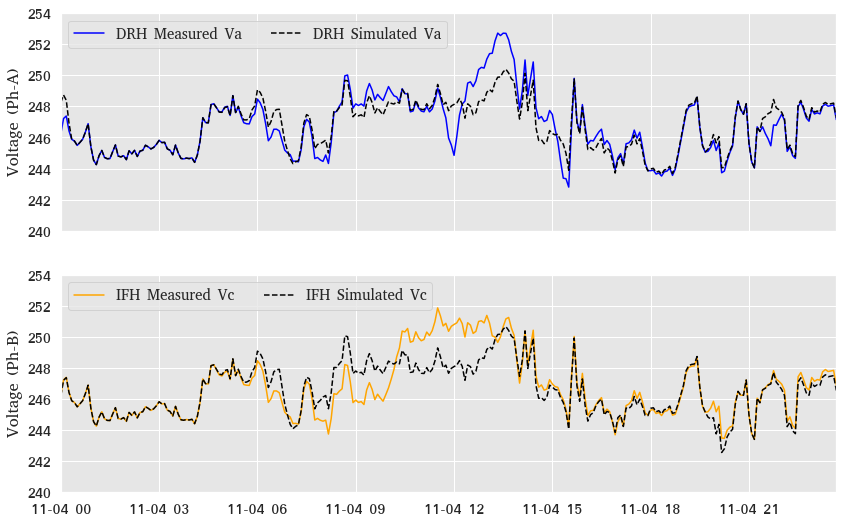

In [22]:
plot_sdhouses_measured_actual(volts_before, volts_after)

In [22]:
#volts_after = time_series_powerflow(scale=1.02)

In [23]:
#plot_measured_actual(volts_before, bus_volts='DR_Va')

In [24]:
phase_a_volts_before = pd.DataFrame(index=volts_after.index)
phase_a_volts_before['TX Va'] = kiosk['AvgUrms1']
phase_a_volts_before['SBRC Va'] = volts_before['SB_Va']
phase_a_volts_before['DRH Va'] = volts_before['DR_Va']
phase_a_volts_before.index = phase_a_volts_before.index.time

In [25]:
phase_a_volts_after = pd.DataFrame(index=volts_after.index)
phase_a_volts_after['TX Va'] = kiosk['AvgUrms1']
phase_a_volts_after['SBRC Va'] = volts_after['SB_Va']
phase_a_volts_after['DRH Va'] = volts_after['DR_Va']
phase_a_volts_after.index = phase_a_volts_after.index.time

In [26]:
phase_c_volts_before = pd.DataFrame(index=volts_before.index)
phase_c_volts_before['TX Vc'] = kiosk['AvgUrms3']
phase_c_volts_before['SBRC Vc'] = volts_before['SB_Vc']
phase_c_volts_before['IFH Vc'] = volts_before['IF_Vc']
phase_c_volts_before.index = phase_c_volts_before.index.time

In [27]:
phase_c_volts_after = pd.DataFrame(index=volts_after.index)
phase_c_volts_after['TX Vc'] = kiosk['AvgUrms3']
phase_c_volts_after['SBRC Vc'] = volts_after['SB_Vc']
phase_c_volts_after['IFH Vc'] = volts_after['IF_Vc']
phase_c_volts_after.index = phase_c_volts_after.index.time

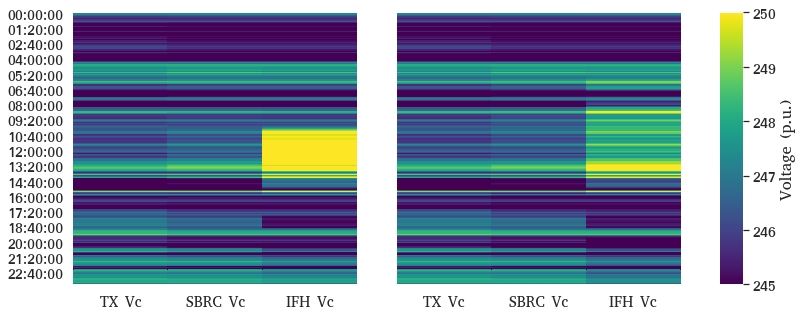

In [28]:
fig, (ax1, ax2, axcb) = plt.subplots(1,3, sharey=False, sharex=False,gridspec_kw={'width_ratios':[1,1,0.08]})
ax1.get_shared_y_axes().join(ax2)
v1 = sns.heatmap(phase_c_volts_before.astype(float), cmap='viridis', vmin=245, vmax=250, cbar=False, ax=ax1)
v2 = sns.heatmap(phase_c_volts_after.astype(float), cmap='viridis', vmin=245, vmax=250, cbar_kws={'label': 'Voltage (p.u.)'}, ax=ax2, cbar_ax=axcb)
v2.set_ylabel('')
v2.set_xlabel('')
v2.set_yticks([])
plt.show()

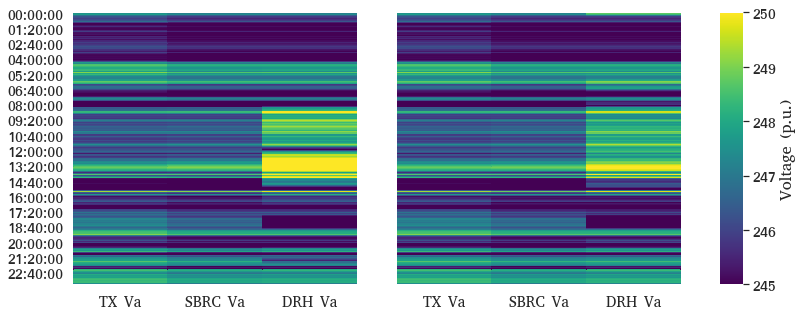

In [29]:
fig, (ax1, ax2, axcb) = plt.subplots(1,3, sharey=False, sharex=False,gridspec_kw={'width_ratios':[1,1,0.08]})
ax1.get_shared_y_axes().join(ax2)
v1 = sns.heatmap(phase_a_volts_before.astype(float), cmap='viridis', vmin=245, vmax=250, cbar=False, ax=ax1)
v2 = sns.heatmap(phase_a_volts_after.astype(float), cmap='viridis', vmin=245, vmax=250, cbar_kws={'label': 'Voltage (p.u.)'}, ax=ax2, cbar_ax=axcb)
v2.set_ylabel('')
v2.set_xlabel('')
v2.set_yticks([])
plt.show()

In [30]:
rbc_drh['p_hvac']

2020-11-04 00:00:00   -0.0
2020-11-04 00:20:00   -0.0
2020-11-04 00:40:00   -0.0
2020-11-04 01:00:00   -0.0
2020-11-04 01:20:00   -0.0
                      ... 
2020-11-05 22:20:00   -0.0
2020-11-05 22:40:00   -0.0
2020-11-05 23:00:00   -0.0
2020-11-05 23:20:00   -0.0
2020-11-05 23:40:00   -0.0
Name: p_hvac, Length: 144, dtype: float64

## Plot gross load and PV data

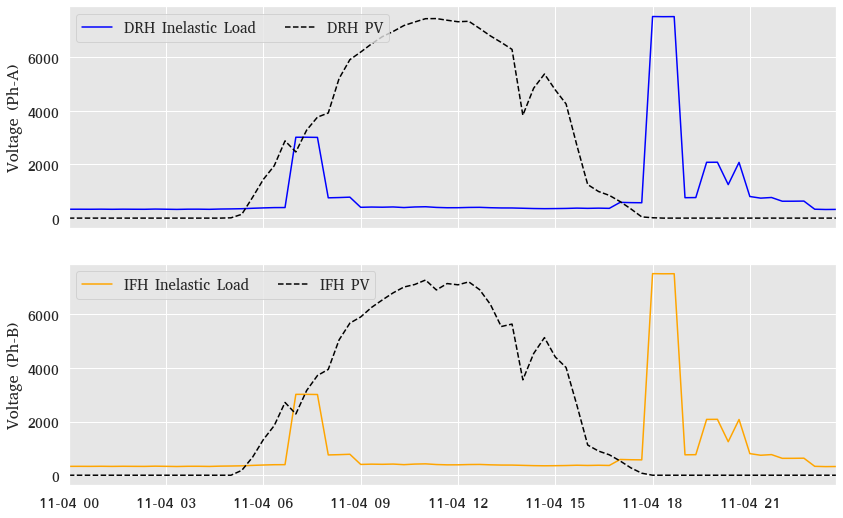

In [31]:
fig, ax = plt.subplots(2, sharex=True)

drh = rbc_drh.loc[date].copy()
ifh = rbc_ifh.loc[date].copy()

ax[0].set_ylabel('Voltage (Ph-A)')
#ax[0].set_ylim(240,254)
ax[0].set_xlim(drh.index[0],drh.index[-1])
ax[0].plot(drh.index, drh['load'], color='blue')
ax[0].plot(drh.index, vr_drh.loc[date]['pv'], color='black',ls='--')
ax[0].legend(['DRH Inelastic Load', 'DRH PV'], loc="upper left", ncol=2)

ax[1].set_ylabel('Voltage (Ph-B)')
#ax[1].set_ylim(240,254)
ax[0].set_xlim(ifh.index[0],ifh.index[-1])
ax[1].plot(ifh.index, ifh['load'], color='orange')
ax[1].plot(ifh.index, ifh['pv'], color='black',ls='--')
ax[1].legend(['IFH Inelastic Load', 'IFH PV'], loc="upper left", ncol=2)


fig.tight_layout()
fig.set_figheight(8)
fig.set_figwidth(12)# otherwise the right y-label is slightly clipped
#     #ax.grid()

#plt.savefig('Figures/sd_house_pandapower_voltages.pdf')
ax[0].autoscale(enable=True, axis='x', tight=True)
ax[1].autoscale(enable=True, axis='x', tight=True)
plt.show()

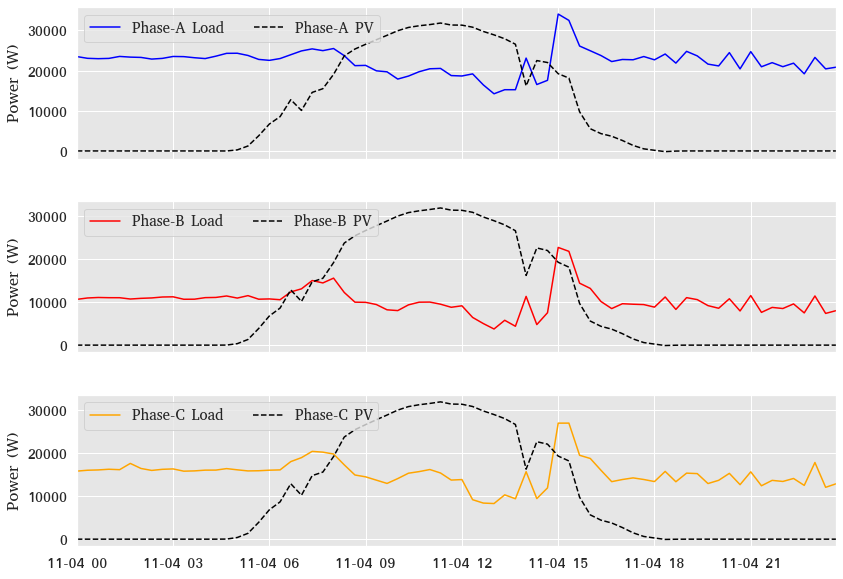

In [32]:
fig, ax = plt.subplots(3, sharex=True)

sb1 = rbc_sb1.loc[date].copy()
sb2 = rbc_sb2.loc[date].copy()
sb3 = rbc_sb3.loc[date].copy()

ax[0].set_ylabel('Power (W)')
ax[0].set_xlim(sb1.index[0],sb1.index[-1])
ax[0].plot(sb1.index,sb1['load'], color='blue')
ax[0].plot(sb1.index, sb1['pv'], color='black',ls='--')
ax[0].legend(['Phase-A Load', 'Phase-A PV'], loc="upper left", ncol=2)

ax[1].set_ylabel('Power (W)')
ax[1].set_xlim(sb1.index[0],sb1.index[-1])
ax[1].plot(sb1.index,sb2['load'], color='red')
ax[1].plot(sb1.index, sb2['pv'], color='black',ls='--')
ax[1].legend(['Phase-B Load', 'Phase-B PV'], loc="upper left", ncol=2)

ax[2].set_ylabel('Power (W)')
ax[2].set_xlim(sb1.index[0],sb1.index[-1])
ax[2].plot(sb1.index,sb3['load'], color='orange')
ax[2].plot(sb1.index, sb3['pv'], color='black',ls='--')
ax[2].legend(['Phase-C Load', 'Phase-C PV'], loc="upper left", ncol=2)

fig.tight_layout()
fig.set_figheight(9)
fig.set_figwidth(12)# otherwise the right y-label is slightly clipped
#     #ax.grid()

#plt.savefig('Figures/sbrc_pandapower_voltages.pdf')
ax[0].autoscale(enable=True, axis='x', tight=True)
ax[1].autoscale(enable=True, axis='x', tight=True)
plt.show()
    

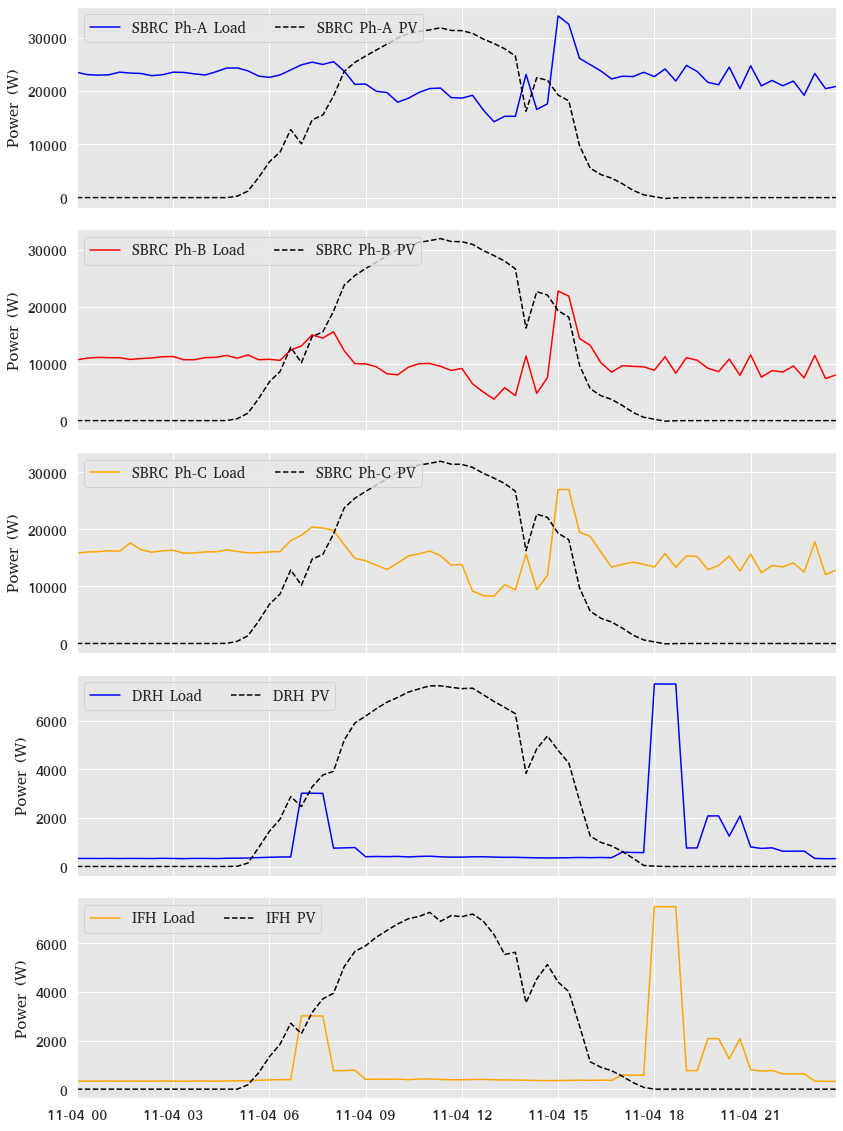

In [33]:
fig, ax = plt.subplots(5, sharex=True)

sb1 = rbc_sb1.loc[date].copy()
sb2 = rbc_sb2.loc[date].copy()
sb3 = rbc_sb3.loc[date].copy()

drh = rbc_drh.loc[date].copy()
ifh = rbc_ifh.loc[date].copy()


ax[0].set_ylabel('Power (W)')
ax[0].set_xlim(sb1.index[0],sb1.index[-1])
ax[0].plot(sb1.index,sb1['load'], color='blue')
ax[0].plot(sb1.index, sb1['pv'], color='black',ls='--')
ax[0].legend(['SBRC Ph-A Load', 'SBRC Ph-A PV'], loc="upper left", ncol=2)

ax[1].set_ylabel('Power (W)')
ax[1].set_xlim(sb1.index[0],sb1.index[-1])
ax[1].plot(sb1.index,sb2['load'], color='red')
ax[1].plot(sb1.index, sb2['pv'], color='black',ls='--')
ax[1].legend(['SBRC Ph-B Load', 'SBRC Ph-B PV'], loc="upper left", ncol=2)

ax[2].set_ylabel('Power (W)')
ax[2].set_xlim(sb1.index[0],sb1.index[-1])
ax[2].plot(sb1.index,sb3['load'], color='orange')
ax[2].plot(sb1.index, sb3['pv'], color='black',ls='--')
ax[2].legend(['SBRC Ph-C Load', 'SBRC Ph-C PV'], loc="upper left", ncol=2)


ax[3].set_ylabel('Power (W)')
#ax[0].set_ylim(240,254)
ax[3].set_xlim(drh.index[0],drh.index[-1])
ax[3].plot(drh.index, drh['load'], color='blue')
ax[3].plot(drh.index, vr_drh.loc[date]['pv'], color='black',ls='--')
ax[3].legend(['DRH Load', 'DRH PV'], loc="upper left", ncol=2)

ax[4].set_ylabel('Power (W)')
#ax[1].set_ylim(240,254)
ax[4].set_xlim(ifh.index[0],ifh.index[-1])
ax[4].plot(ifh.index, ifh['load'], color='orange')
ax[4].plot(ifh.index, ifh['pv'], color='black',ls='--')
ax[4].legend(['IFH Load', 'IFH PV'], loc="upper left", ncol=2)


fig.tight_layout()
fig.set_figheight(16)
fig.set_figwidth(12)# otherwise the right y-label is slightly clipped
#     #ax.grid()
fig.tight_layout()
#plt.savefig('Figures/sbrc_mg_loads.pdf')
ax[0].autoscale(enable=True, axis='x', tight=True)
ax[1].autoscale(enable=True, axis='x', tight=True)

plt.show()
    

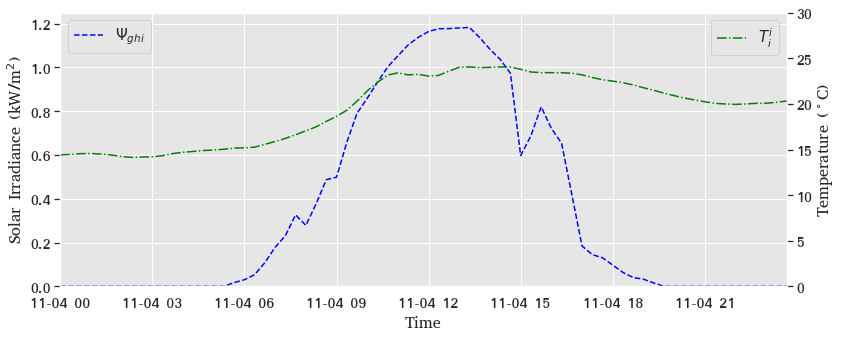

In [34]:
df_thermal = rbc_drh.loc[date].copy()

fig, ax1 = plt.subplots()
ax1.set_xlabel('Time')
ax1.set_ylabel('Solar Irradiance (kW/m$^2$)')
ax1.set_ylim(-0,1.25)
ax1.plot(df_thermal.index, df_thermal['ghi']/1000, label='Power', lw=1.5, color='blue', linestyle='--')
#ax1.plot(df_thermal['time_'], df_electrical['power_3'], label='Temp Bed', lw=3, color='g')
ax1.legend(['$\Psi_{ghi}$', '$\Phi_h$'], loc="upper left")
ax1.set_xlim([df_thermal.index[0], df_thermal.index[-1:][0]])

ax2 = ax1.twinx()
ax2.set_ylabel('Temperature ($^\circ$C)')
ax2.set_ylim(0,30)
#ax2.plot(df_thermal.index, df_thermal['t_av'], label='Temp Bed', lw=2, color='black')
ax2.plot(df_thermal.index, df_thermal['t_ext'], label='Temp Bed', lw=1.5, color='green',  linestyle='-.')
# ax2.plot(df_thermal['time_'], df_thermal['t_std'], label='Temp Bed', lw=3)
# ax2.plot(df_thermal['time_'], df_thermal['t_liv'], label='Temp Bed', lw=3)
# ax2.plot(df_thermal['time_'], df_thermal['t_din'], label='Temp Ext', lw=3)
ax2.legend(['$T_a$'])

fig.tight_layout()
fig.set_figheight(5)
fig.set_figwidth(12)# otherwise the right y-label is slightly clipped
ax2.grid()
plt.savefig(f'Figures/sbrc_mg_vr_simdata_weather.pdf', bbox_inches='tight')
plt.show()

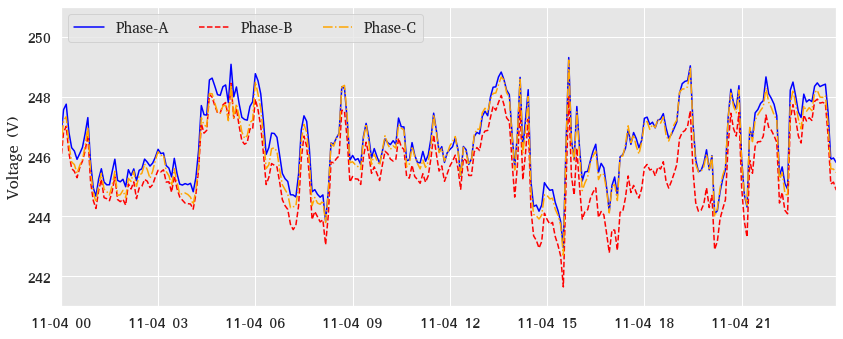

In [35]:
fig, ax = plt.subplots(1)

kp = kiosk.loc[date].copy()

ax.set_ylabel('Voltage (V)')
ax.set_ylim(241,251)
ax.set_xlim(kp.index[0],kp.index[-1])
ax.plot(kp.index,kp['AvgUrms1'], color='blue')
ax.plot(kp.index, kp['AvgUrms2'], color='red',ls='--')
ax.plot(kp.index, kp['AvgUrms3'], color='orange',ls='-.')
ax.legend(['Phase-A', 'Phase-B','Phase-C'], loc="upper left", ncol=3)

fig.tight_layout()
fig.set_figheight(5)
fig.set_figwidth(12)# otherwise the right y-label is slightly clipped

plt.savefig('Figures/sbrc_mg_slack.pdf')
plt.show()

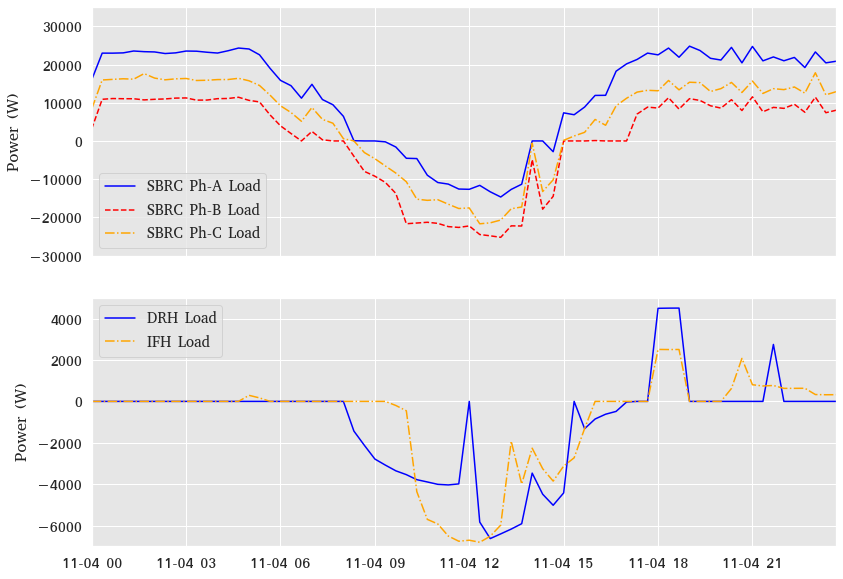

In [36]:
fig, ax = plt.subplots(2, sharex=True)

sb1 = rbc_sb1.loc[date].copy()
sb2 = rbc_sb2.loc[date].copy()
sb3 = rbc_sb3.loc[date].copy()

drh = rbc_drh.loc[date].copy()
ifh = rbc_ifh.loc[date].copy()


ax[0].set_ylabel('Power (W)')
ax[0].set_xlim(sb1.index[0],sb1.index[-1])
ax[0].set_ylim(-30000,35000)
ax[0].plot(sb1.index,sb1['p_im']+sb1['p_ex'], color='blue')
ax[0].plot(sb1.index,sb2['p_im']+sb2['p_ex'], color='red', ls='--')
ax[0].plot(sb1.index,sb3['p_im']+sb3['p_ex'], color='orange', ls='-.')
# ax[0].plot(sb1.index, sb1['pv'], color='black',ls='--')
ax[0].legend(['SBRC Ph-A Load', 'SBRC Ph-B Load', 'SBRC Ph-C Load'], loc="lower left", ncol=1)

ax[1].set_ylabel('Power (W)')
ax[1].set_xlim(sb1.index[0],sb1.index[-1])
ax[1].set_ylim(-7000,5000)
ax[1].plot(drh.index, drh['p_im']+ drh['p_ex'], color='blue')
ax[1].plot(ifh.index, ifh['p_im']+ ifh['p_ex'], color='orange',  ls='-.')
#ax[1].plot(sb1.index,sb2['p_im']+sb2['p_ex'], color='red')
#ax[1].plot(sb1.index, sb2['pv'], color='black',ls='--')
ax[1].legend(['DRH Load', 'IFH Load'], loc="upper left", ncol=1)



fig.set_figheight(9)
fig.set_figwidth(12)# otherwise the right y-label is slightly clipped
#     #ax.grid()


ax[0].autoscale(enable=True, axis='x', tight=True)
ax[1].autoscale(enable=True, axis='x', tight=True)
fig.tight_layout()
plt.savefig('Figures/rbc_net_load.pdf')
plt.show()
    

In [37]:
print((sb1['p_im']+sb1['p_ex']).min())
print((sb2['p_im']+sb2['p_ex']).min())
print((sb3['p_im']+sb3['p_ex']).min())
print((drh['p_im']+drh['p_ex']).min())
print((ifh['p_im']+ifh['p_ex']).min())

-14668.49999806347
-25216.249999999327
-21678.77499589309
-6627.057946122981
-6805.249979218251


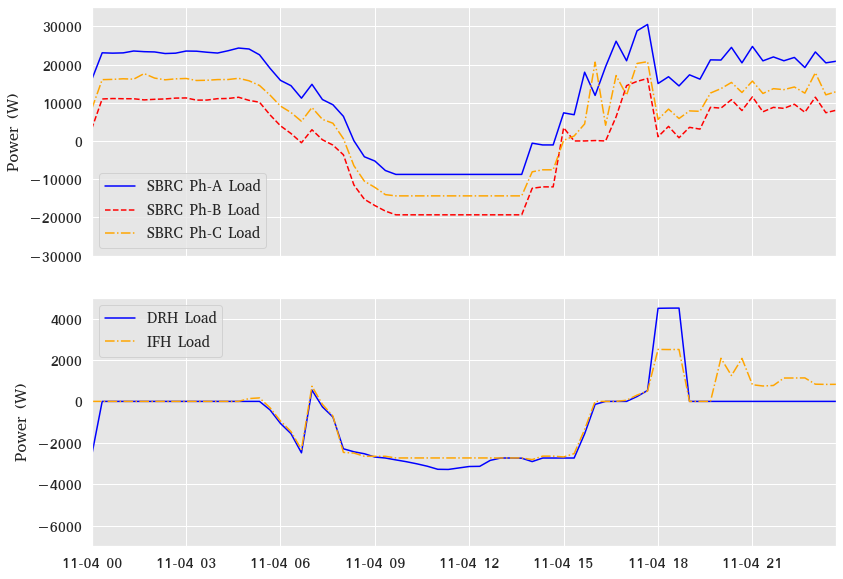

In [38]:
fig, ax = plt.subplots(2, sharex=True)

sb1 = vr_sb1.loc[date].copy()
sb2 = vr_sb2.loc[date].copy()
sb3 = vr_sb3.loc[date].copy()

drh = vr_drh.loc[date].copy()
ifh = vr_ifh.loc[date].copy()


ax[0].set_ylabel('Power (W)')
ax[0].set_xlim(sb1.index[0],sb1.index[-1])
ax[0].set_ylim(-30000,35000)
ax[0].plot(sb1.index,sb1['p_im']+sb1['p_ex'], color='blue')
ax[0].plot(sb1.index,sb2['p_im']+sb2['p_ex'], color='red', ls='--')
ax[0].plot(sb1.index,sb3['p_im']+sb3['p_ex'], color='orange', ls='-.')
# ax[0].plot(sb1.index, sb1['pv'], color='black',ls='--')
ax[0].legend(['SBRC Ph-A Load', 'SBRC Ph-B Load', 'SBRC Ph-C Load'], loc="lower left", ncol=1)

ax[1].set_ylabel('Power (W)')
ax[1].set_xlim(sb1.index[0],sb1.index[-1])
ax[1].set_ylim(-7000,5000)
ax[1].plot(drh.index, drh['p_im']+ drh['p_ex'], color='blue')
ax[1].plot(ifh.index, ifh['p_im']+ ifh['p_ex'], color='orange',  ls='-.')
#ax[1].plot(sb1.index,sb2['p_im']+sb2['p_ex'], color='red')
#ax[1].plot(sb1.index, sb2['pv'], color='black',ls='--')
ax[1].legend(['DRH Load', 'IFH Load'], loc="upper left", ncol=1)



fig.set_figheight(9)
fig.set_figwidth(12)# otherwise the right y-label is slightly clipped
#     #ax.grid()
ax[0].autoscale(enable=True, axis='x', tight=True)
ax[1].autoscale(enable=True, axis='x', tight=True)
plt.savefig('Figures/mpc_net_load.pdf')
fig.tight_layout()
plt.show()
    

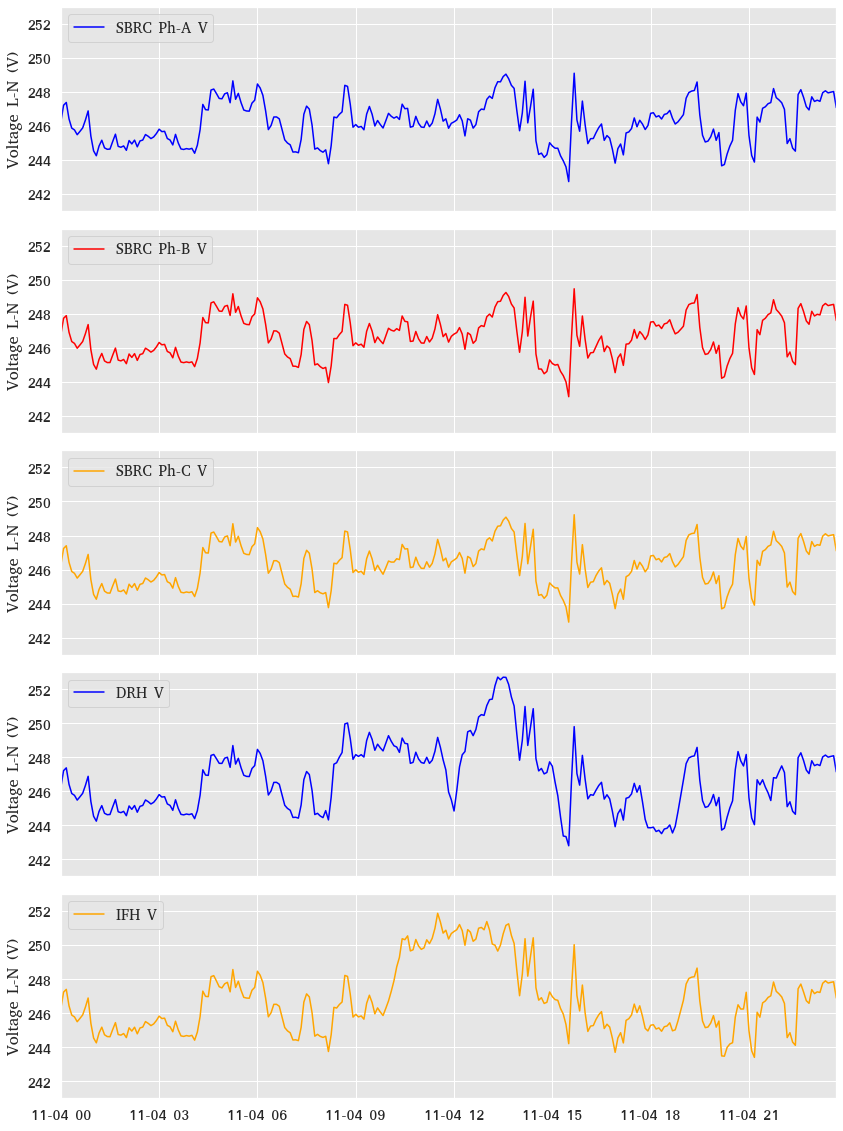

In [39]:
fig, ax = plt.subplots(5, sharex=True)

ax[0].set_ylabel('Voltage L-N (V)')
ax[0].set_xlim(volts_before.index[0],volts_before.index[-1])
ax[0].set_ylim(241,253)
ax[0].plot(volts_before.index,volts_before['SB_Va'], color='blue')
#ax[0].plot(sb1.index, sb1['pv'], color='black',ls='--')
ax[0].legend(['SBRC Ph-A V'], loc="upper left", ncol=2)

ax[1].set_ylabel('Voltage L-N (V)')
ax[1].set_xlim(volts_before.index[0],volts_before.index[-1])
ax[1].set_ylim(241,253)
ax[1].plot(volts_before.index,volts_before['SB_Vb'], color='red')
#ax[0].plot(sb1.index, sb1['pv'], color='black',ls='--')
ax[1].legend(['SBRC Ph-B V'], loc="upper left", ncol=2)

ax[2].set_ylabel('Voltage L-N (V)')
ax[2].set_xlim(volts_before.index[0],volts_before.index[-1])
ax[2].set_ylim(241,253)
ax[2].plot(volts_before.index,volts_before['SB_Vc'], color='orange')
#ax[2].plot(sb1.index, sb1['pv'], color='black',ls='--')
ax[2].legend(['SBRC Ph-C V'], loc="upper left", ncol=2)


ax[3].set_ylabel('Voltage L-N (V)')
ax[3].set_xlim(volts_before.index[0],volts_before.index[-1])
ax[3].set_ylim(241,253)
ax[3].plot(volts_before.index,volts_before['DR_Va'], color='blue')
#ax[3].plot(sb1.index, sb1['pv'], color='black',ls='--')
ax[3].legend(['DRH V'], loc="upper left", ncol=2)

ax[4].set_ylabel('Voltage L-N (V)')
ax[4].set_ylim(241,253)
ax[4].set_xlim(volts_before.index[0],volts_before.index[-1])
ax[4].plot(volts_before.index,volts_before['IF_Vc'], color='orange')
#ax[4].plot(sb1.index, sb1['pv'], color='black',ls='--')
ax[4].legend(['IFH V'], loc="upper left", ncol=2)


fig.tight_layout()
fig.set_figheight(16)
fig.set_figwidth(12)# otherwise the right y-label is slightly clipped
#     #ax.grid()
fig.tight_layout()
plt.savefig('Figures/sbrc_mg_rbc_volts.pdf')
ax[0].autoscale(enable=True, axis='x', tight=True)
ax[1].autoscale(enable=True, axis='x', tight=True)

plt.show()
    

### Minutes above 250V - RBC

In [41]:
len(volts_before['IF_Vc'][volts_before['IF_Vc']>=250])*5

180

In [43]:
len(volts_before['DR_Va'][volts_before['DR_Va']>=250])*5

85

### Maximum voltages - RBC

In [44]:
volts_before['IF_Vc'].max()

251.86503062055436

In [45]:
volts_before['DR_Va'].max()

252.71267966366847

## Net Load Profiles MPC

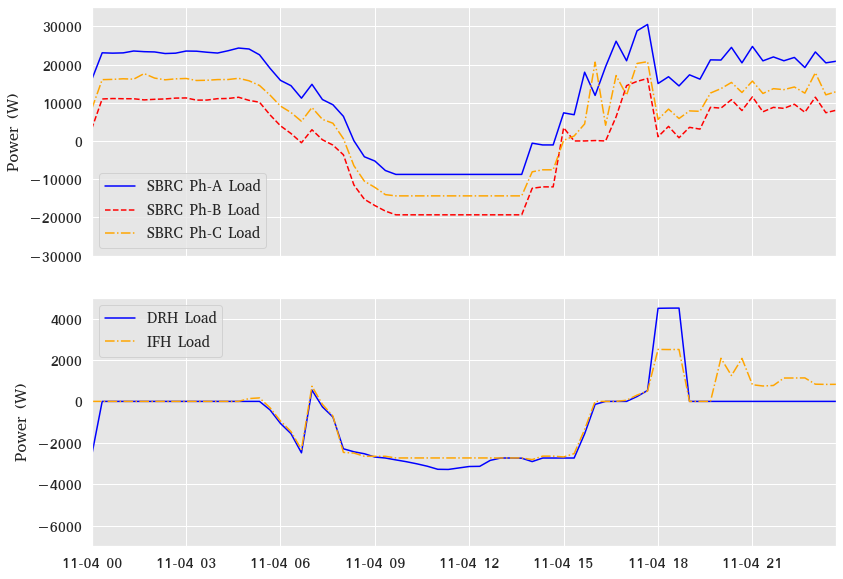

In [47]:
fig, ax = plt.subplots(2, sharex=True)

sb1 = vr_sb1.loc[date].copy()
sb2 = vr_sb2.loc[date].copy()
sb3 = vr_sb3.loc[date].copy()

drh = vr_drh.loc[date].copy()
ifh = vr_ifh.loc[date].copy()


ax[0].set_ylabel('Power (W)')
ax[0].set_xlim(sb1.index[0],sb1.index[-1])
ax[0].set_ylim(-30000,35000)
ax[0].plot(sb1.index,sb1['p_im']+sb1['p_ex'], color='blue')
ax[0].plot(sb1.index,sb2['p_im']+sb2['p_ex'], color='red', ls='--')
ax[0].plot(sb1.index,sb3['p_im']+sb3['p_ex'], color='orange', ls='-.')
# ax[0].plot(sb1.index, sb1['pv'], color='black',ls='--')
ax[0].legend(['SBRC Ph-A Load', 'SBRC Ph-B Load', 'SBRC Ph-C Load'], loc="lower left", ncol=1)

ax[1].set_ylabel('Power (W)')
ax[1].set_xlim(sb1.index[0],sb1.index[-1])
ax[1].set_ylim(-7000,5000)
ax[1].plot(drh.index, drh['p_im']+ drh['p_ex'], color='blue')
ax[1].plot(ifh.index, ifh['p_im']+ ifh['p_ex'], color='orange',  ls='-.')
#ax[1].plot(sb1.index,sb2['p_im']+sb2['p_ex'], color='red')
#ax[1].plot(sb1.index, sb2['pv'], color='black',ls='--')
ax[1].legend(['DRH Load', 'IFH Load'], loc="upper left", ncol=1)


fig.tight_layout()
fig.set_figheight(9)
fig.set_figwidth(12)# otherwise the right y-label is slightly clipped
#     #ax.grid()

plt.savefig('Figures/mpc_net_load.pdf')
ax[0].autoscale(enable=True, axis='x', tight=True)
ax[1].autoscale(enable=True, axis='x', tight=True)
plt.show()

In [48]:
print((sb1['p_im']+sb1['p_ex']).min())
print((sb2['p_im']+sb2['p_ex']).min())
print((sb3['p_im']+sb3['p_ex']).min())
print((drh['p_im']+drh['p_ex']).min())
print((ifh['p_im']+ifh['p_ex']).min())

-8755.371794871793
-19332.326923076933
-14373.24423076923
-3287.742152864892
-2810.8404798402385


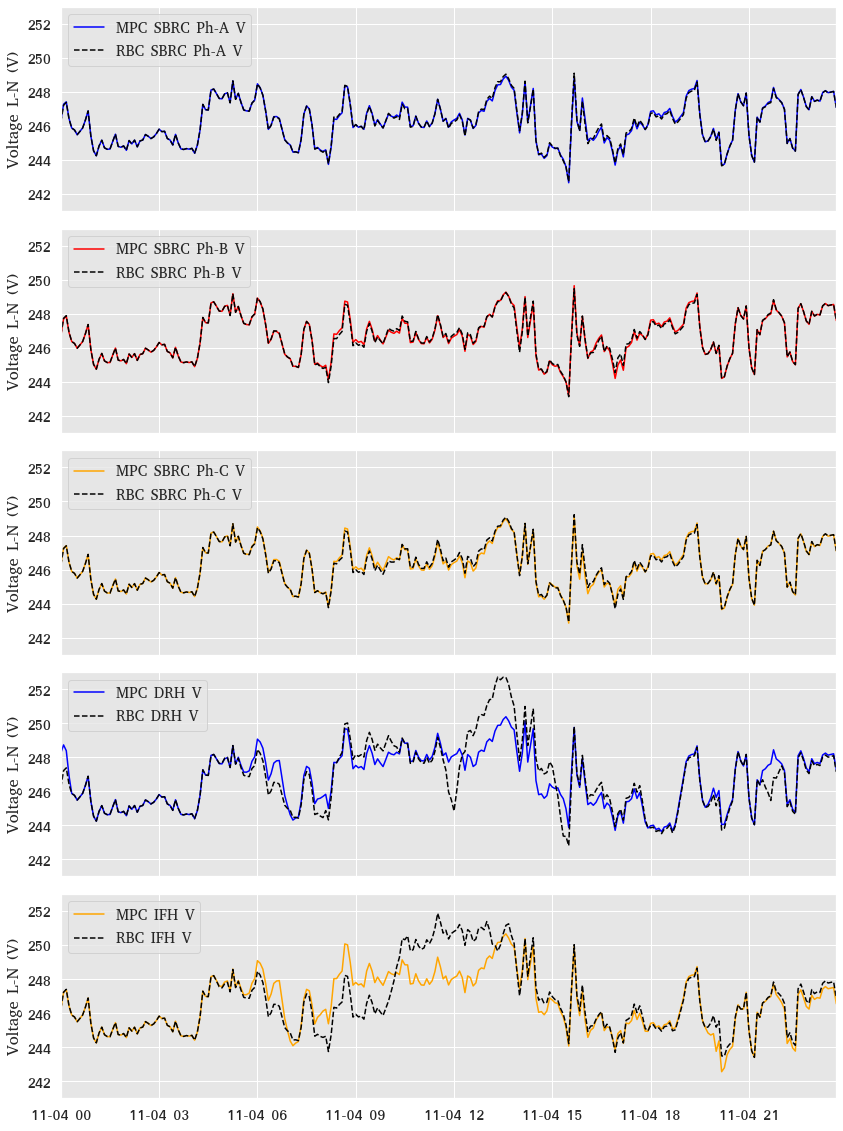

In [53]:
fig, ax = plt.subplots(5, sharex=True)

ax[0].set_ylabel('Voltage L-N (V)')
ax[0].set_xlim(volts_before.index[0],volts_before.index[-1])
ax[0].set_ylim(241,253)
ax[0].plot(volts_after.index,volts_after['SB_Va'], color='blue')
ax[0].plot(volts_before.index,volts_before['SB_Va'], color='black',ls='--')
ax[0].legend(['MPC SBRC Ph-A V','RBC SBRC Ph-A V'], loc="upper left", ncol=1)

ax[1].set_ylabel('Voltage L-N (V)')
ax[1].set_xlim(volts_before.index[0],volts_before.index[-1])
ax[1].set_ylim(241,253)
ax[1].plot(volts_after.index,volts_after['SB_Vb'], color='red')
ax[1].plot(volts_before.index,volts_before['SB_Vb'], color='black',ls='--')
ax[1].legend(['MPC SBRC Ph-B V','RBC SBRC Ph-B V'], loc="upper left", ncol=1)

ax[2].set_ylabel('Voltage L-N (V)')
ax[2].set_xlim(volts_before.index[0],volts_before.index[-1])
ax[2].set_ylim(241,253)
ax[2].plot(volts_after.index,volts_after['SB_Vc'], color='orange')
ax[2].plot(volts_before.index,volts_before['SB_Vc'], color='black',ls='--')
ax[2].legend(['MPC SBRC Ph-C V','RBC SBRC Ph-C V'], loc="upper left", ncol=1)


ax[3].set_ylabel('Voltage L-N (V)')
ax[3].set_xlim(volts_before.index[0],volts_before.index[-1])
ax[3].set_ylim(241,253)
ax[3].plot(volts_after.index,volts_after['DR_Va'], color='blue')
ax[3].plot(volts_before.index,volts_before['DR_Va'], color='black',ls='--')
ax[3].legend(['MPC DRH V','RBC DRH V'], loc="upper left", ncol=1)

ax[4].set_ylabel('Voltage L-N (V)')
ax[4].set_ylim(241,253)
ax[4].set_xlim(volts_before.index[0],volts_before.index[-1])
ax[4].plot(volts_after.index,volts_after['IF_Vc'], color='orange')
ax[4].plot(volts_before.index,volts_before['IF_Vc'], color='black',ls='--')
ax[4].legend(['MPC IFH V', 'RBC IFH V'], loc="upper left", ncol=1)


fig.tight_layout()
fig.set_figheight(16)
fig.set_figwidth(12)# otherwise the right y-label is slightly clipped
#     #ax.grid()
fig.tight_layout()
plt.savefig('Figures/sbrc_mg_rbc_mpc_volts.pdf')
ax[0].autoscale(enable=True, axis='x', tight=True)
ax[1].autoscale(enable=True, axis='x', tight=True)

plt.show()
    

### Minutes above 250V - MPC

In [54]:
len(volts_after['IF_Vc'][volts_after['IF_Vc']>=250])*5

45

In [56]:
len(volts_after['DR_Va'][volts_after['DR_Va']>=250])*5

20

In [57]:
volts_after['IF_Vc'].max()

250.65859013420092

In [58]:
volts_after['DR_Va'].max()

250.38444449015432